# Plot the residence time and protein bound ratio for model A (Nonly)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [4]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.Nonly import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [5]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M
color_gamma = 'tab:green'
color_CP0 = 'tab:red'
color_kbP = 'tab:orange'

## edge case, dense protein

In [10]:
parm_file = GenParameters(
    ifwrite=False, hasTargets=False, lengthScale=50,
    KPN=np.array([2e2,1e3,2e3]),
    NP0 = np.linspace(10, 100), KPP=[1e4], kbPP_fixed=0.4,
    area3Dto1D = [10], 
)
parm_num = GenParameters(
    ifwrite=False, hasTargets=False, lengthScale=50,
    KPN=np.array([2e2,1e3,2e3]),
    NP0 = np.linspace(10, 100, 10), KPP=[1e4], kbPP_fixed=0.4,
    area3Dto1D = [10], 
)

In [11]:
def tauA_rev(parm):
    equiCP = np.zeros(parm.shape[0])
    for iloc in range(parm.shape[0]):
        equiCP[iloc] = ana.ana_equi_CP(parm.iloc[iloc], numClusterS=0)
    gamma = parm_file['gamma']
    KPP = parm['KPP']
    chiPN = parm['KPN']*parm['CN0']
    OffP_OffN = parm_file['kbPP']/parm_file['kbPN']
    num = (1/(KPP*equiCP) + 4 + 2*gamma*chiPN)
    den = (1/(KPP*equiCP) + 4 + 2*OffP_OffN)
    return num/den / parm_file['kbPN']

resT_A_rev = tauA_rev(parm_file)

In [12]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

2024-10-03 15:13:13.743993
Number of cores used:  30/36
Finished parallel processing.


In [13]:
resT_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    resT_num_rev[iloc] = num.calc_resT_modelA(parm, equi_num_rev.iloc[iloc])

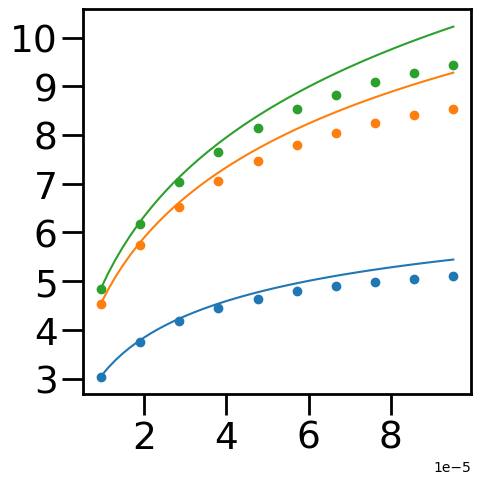

In [18]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kpnList = np.unique(parm_file['KPN'])
for i, kpn in enumerate(kpnList):
    selected = (parm_file['KPN']==kpn)
    selected_num = (parm_num['KPN']==kpn)

    # analytical, monomer
    ax.plot(
        # (parm_file['CP0']/parm_file['CN0'])[selected],
        (parm_file['CP0'])[selected],
        (resT_A_rev*parm_file['kbPN'])[selected],
        color=colors[i],
    )
    # numerical
    ax.scatter(
        # (parm_num['CP0']/parm_num['CN0'])[selected],
        (parm_num['CP0'])[selected],
        (resT_num_rev*parm_num['kbPN'])[selected],
        color=colors[i],
    )

# ax.semilogx()
# plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma.png', transparent=True)

## real-b) residence time v.s. chiPN & gamma, irreversible

In [31]:
parm_file = GenParameters(
    ifwrite=False, hasTargets = False,
    KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], 
    KPN=np.logspace(1, 3, 5+2*20)*2.0, 
    KPP=[np.exp(23)], 
    area3Dto1D=[1, 100], lengthScale=1,
)

In [32]:
def tauA_irr(parm):
    gam = parm['gamma']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    return (1+gam*chiN/2)/koffN

def tauA_monomer(parm):
    return 1 / parm['kbPN']

resT_A_irr = tauA_irr(parm_file)
resT_A_m = tauA_monomer(parm_file)

In [33]:
# parm_num = GenerateParameters_or_write(ifwrite=False, plotDenseData=False)
parm_num = GenParameters(
    ifwrite=False, hasTargets = False,
    KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], 
    KPN=np.logspace(1, 3, 5+2*0)*2.0, 
    KPP=[0], 
    area3Dto1D=[1, 100], lengthScale=1,
)
parm_num_irr = GenParameters(
    ifwrite=False, hasTargets = False,
    KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], 
    KPN=np.logspace(1, 3, 5+2*0)*2.0, 
    KPP=[np.inf], 
    area3Dto1D=[1, 100], lengthScale=1,
)
equi_num_irr = numericSolver(parm_df=parm_num_irr, labels=labels, model=rxnNetwork)
equi_num_m = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

2024-10-07 16:12:20.837030
Number of cores used:  10/36
Finished parallel processing.
2024-10-07 16:12:21.006668
Number of cores used:  10/36
Finished parallel processing.


In [34]:
resT_num_m = np.zeros(parm_num.shape[0])
resT_num_irr = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    resT_num_m[iloc] = num.calc_resT_modelA(parm, equi_num_m.iloc[iloc])
    resT_num_irr[iloc] = num.calc_resT_modelA(parm, equi_num_irr.iloc[iloc])

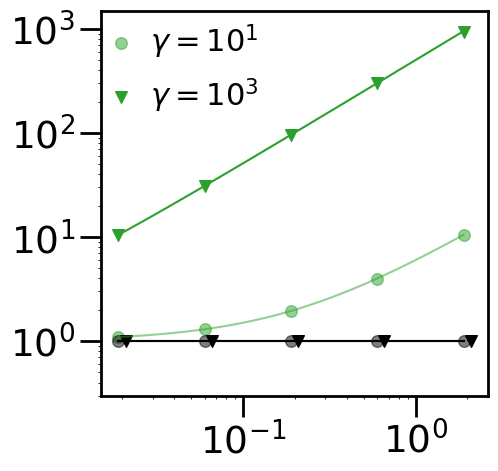

In [36]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.70], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
color_gamma = 'tab:green'
alphas = [0.5, 1]
markers = ['o','v']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList):
    selected = (parm_file['gamma']==gam)
    selected_num = (parm_num['gamma']==gam)
    # analytical, irreversible
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        (resT_A_irr*parm_file['kbPN'])[selected],
        color=color_gamma, alpha=alphas[i]
    )
    # analytical, monomer
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        (resT_A_m*parm_file['kbPN'])[selected],
        color='black',
    )
    # numerical
    ax.scatter(
        (parm_num['KPN']*parm_num['CN0'])[selected],
        (resT_num_irr*parm_num['kbPN'])[selected],
        color=color_gamma, alpha=alphas[i], s=70,
        marker=markers[i], label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    ax.scatter(
        (parm_num['KPN']*parm_num['CN0'])[selected]*(1+i/10),
        (resT_num_m*parm_num['kbPN'])[selected], s=70,
        color='black', alpha=alphas[i], marker=markers[i], 
    )

ax.loglog()
ax.set_ylim([3e-1,1.5e3])
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_chiN_gamma.png', transparent=True)

## b) residence time v.s. KPP & CP0

In [164]:
genParms = lambda N: GenParameters(
    ifwrite=False, hasTargets = False,
    KPN=[200], KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], #CP0=10.0**np.array([(1-9), (3-9), (5-9)]), 
    KPP=np.logspace(1,10,10+9*N), 
    area3Dto1D=[1, 1000],
)
parm_file = genParms(10)
parm_num = genParms(0)

In [165]:
def tauA_rev(parm):
    equiCP = np.zeros(parm.shape[0])
    for iloc in range(parm.shape[0]):
        equiCP[iloc] = ana.ana_equi_CP(parm.iloc[iloc], numClusterS=0)
    gamma = parm_file['gamma']
    KPP = parm['KPP']
    chiPN = parm['KPN']*parm['CN0']
    OffP_OffN = parm_file['kbPP']/parm_file['kbPN']
    num = (1/(KPP*equiCP) + 4 + 2*gamma*chiPN)
    den = (1/(KPP*equiCP) + 4 + 2*OffP_OffN)
    return num/den / parm_file['kbPN']

resT_A_rev = tauA_rev(parm_file)
equi_num_rev = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

2024-10-03 16:51:34.810535
Number of cores used:  20/36
Finished parallel processing.


In [166]:
resT_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    resT_num_rev[iloc] = num.calc_resT_modelA(parm, equi_num_rev.iloc[iloc])

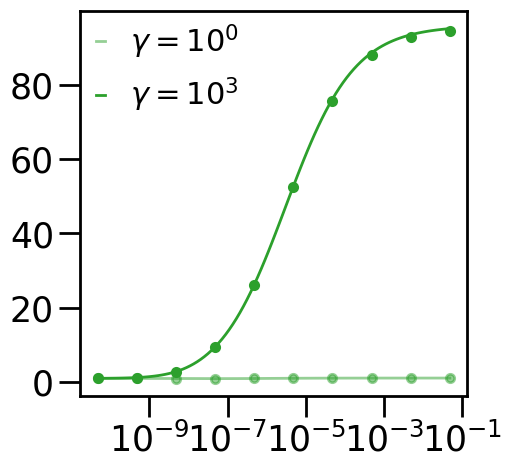

In [167]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.7], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=25, 
    tickL=15, tickW=2, spineLineW=2
)
color_CP0 = 'tab:red'
color_gamma = 'tab:green'
alphas = [1/2, 2/2]
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# CP0List = np.unique(parm_file['CP0'])
# for i, CP0 in enumerate(CP0List):
gammaList = np.unique(parm_file['gamma'])
for i, gamma in enumerate(gammaList):
#     selected = (parm_file['CP0']==CP0)
#     selected_num = (parm_num['CP0']==CP0)
    selected = (parm_file['gamma']==gamma)
    selected_num = (parm_num['gamma']==gamma)
    ax.plot(
        (parm_file['KPP']*parm_file['CP0'])[selected]*C0/1e6,
        (resT_A_rev*parm_file['kbPN'])[selected],
        lw=2, label='$\\gamma=10^{%.0f}$'%np.log10(gamma),
        color=color_gamma, alpha=alphas[i],
    )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num]*C0/1e6,
        (resT_num_rev*parm_num['kbPN'])[selected_num],
        lw=2, zorder=5,
        color=color_gamma, alpha=alphas[i], 
    )
ax.semilogx()
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.savefig('resT_vs_KPP_CP0.png', transparent=True)

### subplot (abnormal behavior)

In [235]:
genParm = lambda N: GenParameters(
    ifwrite=False, hasTargets = False,
    KPN=[2000], KPS=lambda KPN: 1e3*KPN, 
    CP0=[1e0*1e-6,1e1*1e-6,1e2*1e-6], KPP=np.logspace(1,10,10+9*N), 
    area3Dto1D=[1000],
)
parm_file = genParm(10)
parm_num = genParm(0)

In [236]:
def tauA_rev(parm):
    equiCP = np.zeros(parm.shape[0])
    for iloc in range(parm.shape[0]):
        equiCP[iloc] = ana.ana_equi_CP(parm.iloc[iloc], numClusterS=0)
    gamma = parm_file['gamma']
    KPP = parm['KPP']
    chiPN = parm['KPN']*parm['CN0']
    OffP_OffN = parm_file['kbPP']/parm_file['kbPN']
    num = (1/(KPP*equiCP) + 4 + 2*gamma*chiPN)
    den = (1/(KPP*equiCP)+4+2*OffP_OffN)
    return num/den / parm_file['kbPN']

resT_A_rev = tauA_rev(parm_file)
equi_num_rev = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

resT_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    resT_num_rev[iloc] = num.calc_resT_modelA(parm, equi_num_rev.iloc[iloc])

2024-10-03 17:38:01.396699
Number of cores used:  30/36
Finished parallel processing.


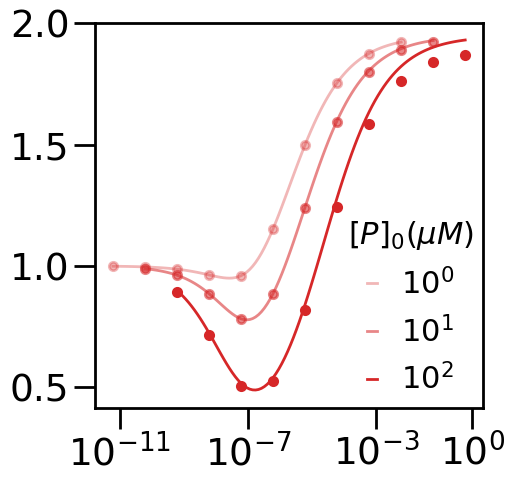

In [240]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.62,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='$[P]_0 (\mu M)$', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
color_CP0 = 'tab:red'
alphas = [3/9, 5/9, 1]
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

CP0List = np.unique(parm_file['CP0'])
for i, CP0 in enumerate(CP0List):
    selected = (parm_file['CP0']==CP0)
    selected_num = (parm_num['CP0']==CP0)
    ax.plot(
        (parm_file['KPP']*parm_file['CP0'])[selected]*C0/1e6,
        (resT_A_rev*parm_file['kbPN'])[selected],
        lw=2, color=color_CP0, alpha=alphas[i],
        label='$10^{%.0f}$'%np.log10(CP0/C0*1e6)
    )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num]*C0/1e6,
        (resT_num_rev*parm_num['kbPN'])[selected_num],
        lw=2, zorder=5,
        color=color_CP0, alpha=alphas[i], 
    )
ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-11, 1e-7, 1e-3, 1e0],**tickfont)
plt.yticks([0.5, 1, 1.5, 2], **tickfont)
plt.savefig('resT_vs_KPP_CP0.png', transparent=True)

## d) protein bound ratio v.s. KPP

In [21]:
parm_file = GenParameters(
    ifwrite=False, hasTargets = False,
    KPN=[2e1,2e2,2e3], KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPP=np.logspace(1,10,10+9*10), 
    area3Dto1D=[10],
)
parm_num = GenParameters(
    ifwrite=False, hasTargets = False,
    KPN=[2e1,2e2,2e3], KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPP=np.logspace(1,10,10+9*0), 
    area3Dto1D=[10],
)

In [22]:
pBound = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=0)

In [23]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

pBound_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelA(parm, equi_num_rev.iloc[iloc])

2024-10-04 09:31:56.647116
Number of cores used:  30/36
Finished parallel processing.


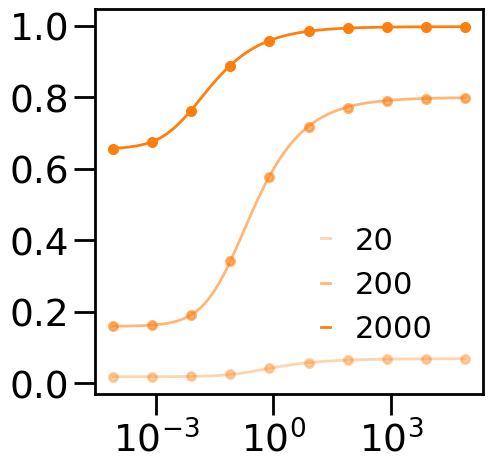

In [26]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.10], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

KPNList = np.unique(parm_file['KPN'])
# for i, gam in enumerate(gamList):
for j, KPN in enumerate(KPNList):
    selected = ((parm_file['KPN']==KPN))
    selected_num = ((parm_num['KPN']==KPN))
    ax.plot(
        (parm_file['KPP']*parm_file['CP0'])[selected],
        pBound[selected],
        ls = '-', color = color_kpn, alpha = alphas[j],
        lw=2,
        label='%.0f'%(KPN*C0)
    )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        pBound_num_rev[selected_num],alpha = alphas[j],
        ls = '-', color = color_kpn, lw=2,
    )

ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e0, 1e3], ['$10^{-3}$', '$10^{0}$', '$10^{3}$'], **tickfont)
plt.yticks(**tickfont)
plt.savefig('pBound_vs_KPP_KPN.png', transparent=True)

## real-c) kbP and KPP\*CP0

In [43]:
GenParms = lambda kbP, nDenseKPP :GenParameters(
    ifwrite=False, numTargets=0, kbPP_fixed=kbP,   
    KPN=[200], NP0=[0.1], area3Dto1D=[114],
    # KPP=np.logspace(1,9,8+7*nDenseKPP), 
    KPP=[1e0, 1e3, 1e6], 
)

In [44]:
parm_num = pd.concat([GenParms(0.1, 0), GenParms(1, 0), GenParms(10, 0)], axis=0)
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

parm_ana = pd.concat([GenParms(0.1, 10), GenParms(1, 10), GenParms(10, 10)], axis=0)

2024-12-17 12:03:07.804559
Number of cores used:  9/36
Finished parallel processing.


### residence time v.s. KPP*[P]

In [15]:
np.unique(parm_num['gamma']), np.unique(parm_num['gamma']*parm_num['kaPN']*parm_num['CN0'])

(array([8.77192982]), array([1.00250627]))

In [10]:
np.unique(parm_num['kbPN'])*0.6022

array([0.36264484])

In [11]:
def tauA_rev(parm):
    equiCP = np.zeros(parm.shape[0])
    for iloc in range(parm.shape[0]):
        equiCP[iloc] = ana.ana_equi_CP(parm.iloc[iloc], numClusterS=0)
    gamma = parm['gamma']
    KPP = parm['KPP']
    chiPN = parm['KPN']*parm['CN0']
    OffP_OffN = parm['kbPP']/parm['kbPN']
    num = (1/(KPP*equiCP) + 4 + 2*gamma*chiPN)
    den = (1/(KPP*equiCP)+4+2*OffP_OffN)
    return num/den / parm['kbPN']

resT_ana = tauA_rev(parm_ana)

resT_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    resT_num[iloc] = num.calc_resT_modelA(parm, equi_num.iloc[iloc])

2024-11-01 16:37:45.409278
Number of cores used:  24/36
Finished parallel processing.


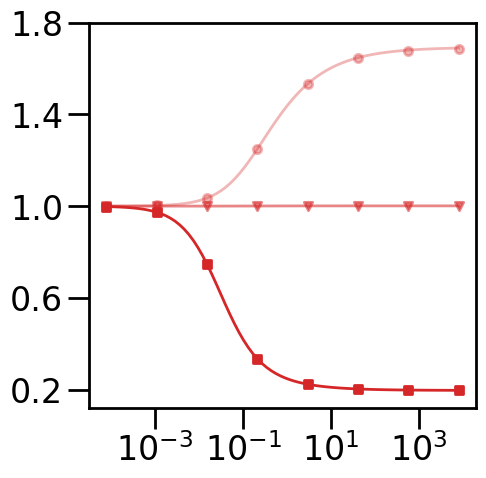

In [12]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.65,0.05], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=24, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

kbPList = np.unique(parm_num['kbPP'])
for i, kbP in enumerate(kbPList):
    selected_ana = (parm_ana['kbPP']==kbP)
    selected_num = (parm_num['kbPP']==kbP)
    ax.plot(
        (parm_ana['KPP']*parm_ana['CP0'])[selected_ana],
        (resT_ana*parm_ana['kbPN'])[selected_ana],
        lw=2, color=color_CP0, alpha=alphas[i],
    )
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (resT_num*parm_num['kbPN'])[selected_num],
        lw=2, zorder=5, marker=markers[i], 
        label='$10^{%.0f}$'%np.log10(kbP),
        color=color_CP0, alpha=alphas[i], 
    )
ax.semilogx()
# plt.legend(**legend)
plt.xticks([1e-3, 1e-1, 1e1, 1e3],**tickfont)
plt.yticks([0.2, 0.6, 1.0, 1.4, 1.8], **tickfont)
plt.savefig('resT_vs_KPP_CP0.png', transparent=True)

### distribution of residence times

In [49]:
from pathlib import Path

pdir = '../Simulations/Gillespie/DNA:criticDimer//'
Path(pdir).mkdir(parents=True, exist_ok=True)
parm_num.to_csv(pdir+'/parameters.csv')
equi_num.to_csv(pdir+'/equilibrium.csv')

In [48]:
def readGillespieSurvP(filename):
    with open(filename) as f:
        reading = False
        times = []
        survP = []
        numDiss = 'Not Read'
        for line in f:
            if line.strip() == '# START SURVIVAL PROB':
                reading = True
            elif line.strip() == '# END SURVIVAL PROB':
                reading = False
            elif line.strip() == '# Mean Residence Time':
                meanResT = float(f.readline().strip())
            elif line.strip().startswith('Number of dissociation events:'):
                numDiss = int(line.split(':')[1])
            else:
                if reading:
                    linelist = line.split()
                    times.append(float(linelist[0]))
                    survP.append(float(linelist[1]))
    return np.array(times), np.array(survP), meanResT, numDiss

def getPDF(fileName, stepSize=2016):
    times, survP, _, _  = readGillespieSurvP(fileName)
    timeX = (times[::stepSize][1:]+times[::stepSize][:-1])/2
    probY = -np.diff(survP[::stepSize])
    return timeX, probY

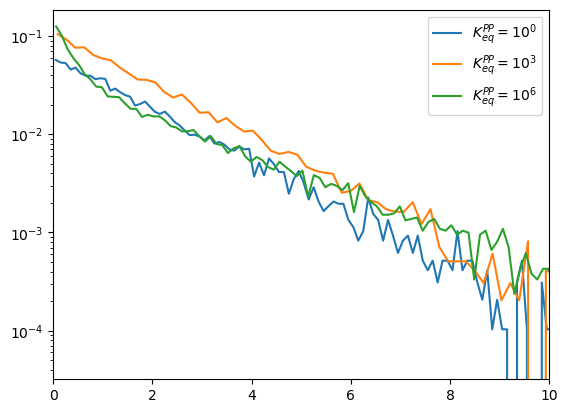

In [40]:
KPPlog10 = [0, 3, 6]
for i in range(3):
    fileName = f'../Simulations/Gillespie/DNA:criticDimer/OUTPUTS_Nonly/out_{i}_r0'
    timeX, probY  = getPDF(fileName, stepSize=4032)
    plt.plot(timeX, probY, label='$K_{eq}^{PP}=10^{%.0f}$'%KPPlog10[i])
plt.legend()
plt.xlim([0,10])
plt.semilogy()
plt.show()

## c) protein bound ratio v.s. KPN

In [262]:
np.log10(np.logspace(1, 3, 5+2*0))

array([1. , 1.5, 2. , 2.5, 3. ])

In [37]:
parm_file = GenParameters(
    ifwrite=False, hasTargets = False,
    KPN=np.logspace(1, 3, 5+2*40)*2.0, KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPP=[np.inf], area3Dto1D=[1, 100],
)
parm_num_m = GenParameters(
    ifwrite=False, hasTargets = False,
    KPN=10**np.array([1, 1.05 , 1.5,1.55,  2.,2.05,  2.5,2.55,  3.,3.05 ])*2.0, KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPP=[0], area3Dto1D=[1, 100],
)
parm_num_irr = GenParameters(
    ifwrite=False, hasTargets = False,
    KPN=np.logspace(1, 3, 5+2*0)*2.0, KPS=lambda KPN: 1e3*KPN, 
    NP0=[0.1], KPP=[np.inf], area3Dto1D=[1, 100],
)

In [38]:
def calc_pBoundA_irr(parm):
    gam = parm['gamma']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiPN = KPN*CN
    return (2*chiPN + gam*chiPN**2)/(1 + 2*chiPN + gam*chiPN**2)

def calc_pBoundA_monomer(parm):
    gam = parm['gamma']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiPN = KPN*CN
    return chiPN/(1+chiPN)

pBound_A_irr = calc_pBoundA_irr(parm_file)
pBound_A_m = calc_pBoundA_monomer(parm_file)

In [39]:
equi_num_irr = numericSolver(parm_df=parm_num_irr, labels=labels, model=rxnNetwork)
equi_num_m = numericSolver(parm_df=parm_num_m, labels=labels, model=rxnNetwork)

pBound_num_m = np.zeros(parm_num_m.shape[0])
for iloc in range(parm_num_m.shape[0]):
    pBound_num_m[iloc] = num.calc_BoundRatio_modelA(parm_num_m.iloc[iloc], equi_num_m.iloc[iloc])
    
pBound_num_irr = np.zeros(parm_num_irr.shape[0])
for iloc in range(parm_num_irr.shape[0]):
    pBound_num_irr[iloc] = num.calc_BoundRatio_modelA(parm_num_irr.iloc[iloc], equi_num_irr.iloc[iloc])

2024-10-07 16:13:22.030022
Number of cores used:  10/36
Finished parallel processing.
2024-10-07 16:13:22.204735
Number of cores used:  20/36
Finished parallel processing.


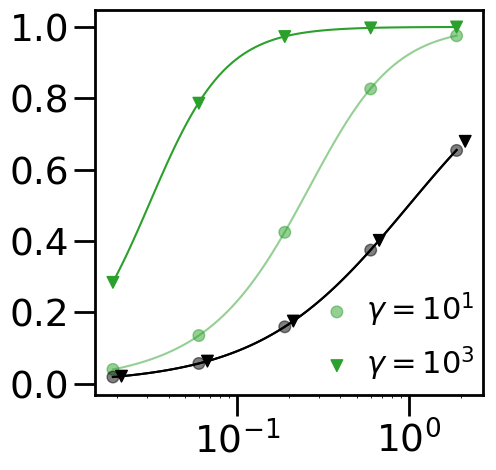

In [41]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.58,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [0.5, 1]
markers = ['o','v']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_file['gamma'])
for j, gam in enumerate(gamList):
    selected = ((parm_file['gamma']==gam))
    # analytics
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        pBound_A_irr[selected],
        color = color_gamma, alpha=alphas[j],
        
    )
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
        pBound_A_m[selected],
        color='black',
    )
    # numerics
    selected_num = ((parm_num_irr['gamma']==gam))
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_irr[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    selected_num = ((parm_num_m['gamma']==gam))
    ax.scatter(
        (parm_num_m['KPN']*parm_num_m['CN0'])[selected_num][j::2],
        pBound_num_m[selected_num][j::2],  s=70,
        marker=markers[j], alpha=alphas[j],
        ls='', color='black',
    )
    

ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
# plt.grid(axis='x')
plt.savefig('pBound_vs_chiN_gamma.png', transparent=True)
# plt.show()

## e) Sensitivity analysis

In [4]:
import numpy as np
import threading

# tau=f(x)
# x = log10(kaN, kbN, kaP, kbP, CP0, gamma)
def f_DNA(x):
    '''Given x, calculate the mean residence time through two-state equilbrium model
    
    Inputs:
        x (list): (KPN, kaP, kbP, CP0, gamma) Note that, kbN=120.44/KPN s^-1
        
    Outputs;
        mean residence times (float)
    '''
    
    import sys
    sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
    # modules for direct calculation
    import analytics as ana
    import analyzeEqui as num
    # stochastic simulation (Gillespie)
    from Simulations.odeSolver.Nonly import rxnNetwork, labels
    from Simulations.odeSolver.main import main as numericSolver
    # for generating parameters
    from GenerateParameters import GenParameters
    ######## finish importing ########
    kaN, kbN, kaP, kbP, CP0, gamma = 10.0**np.array(x)
    if kbP == 0:
        parms = GenParameters(
            ifwrite=False, hasTargets = False,
            KPS=lambda KPN: 1e3*KPN, 
            CP0=[CP0], KPP=[np.inf], kbPP_fixed=kbP,
            gamma=[gamma], KPN=[kaN/kbN], kaPN=kaN,
        )
    else:
        parms = GenParameters(
            ifwrite=False, hasTargets = False,
            KPS=lambda KPN: 1e3*KPN, 
            CP0=[CP0], KPP=[kaP/kbP], kbPP_fixed=kbP,
            gamma=[gamma], KPN=[kaN/kbN], kaPN=kaN,
        )
    # there should be only one set of parameters
    equi = numericSolver(parm_df=parms, labels=labels, model=rxnNetwork, cores=1, ifprint=False)
    # return the mean residence time
    return num.calc_resT_modelA(parms.iloc[0], equi.iloc[0])*kbN

# sensitivity analysis
def sobolSA(problem, numberSamples, model, num_cores=1):
    
    from SALib.analyze import sobol
    from SALib.sample import sobol as sobol_sampling
    from tqdm import tqdm 
    import multiprocessing
    
    def model_with_progress(x):
        result = model(x)
        if pbar is not None:
            pbar.update()
        return result
    
    # Generate parameter samples using Saltelli's method (for Sobol analysis)
    param_values = sobol_sampling.sample(problem, numberSamples)

    num_cores = min(num_cores, multiprocessing.cpu_count())  # Get the number of available CPU cores
    print('Number of cores used: ',f'{num_cores}')
    if num_cores > 1:
        pool = multiprocessing.Pool(processes=num_cores)
        Y = np.array(pool.map(model, param_values))
        pool.close()
        pool.join()
    else:
        # Run the model for each set of parameters
        Y = np.array([model(x) for x in tqdm(param_values, desc="Evaluating model", unit="sample")])
    
    # convert parameters. It was sampled in log space.
#     problem['bounds'] = [10.0**b for b in problem['bounds']]
    # Perform Sobol sensitivity analysis and return 
    return sobol.analyze(problem, Y), Y, param_values

problem = {
    'num_vars': 6,
    'names': ['log $k_a^N$', 'log $k_b^N$', 'log $k_a^P$', 'log $k_b^P$', 'log $[P]_0$', 'log $\\gamma$'],
    'bounds': [
        np.log10([2, 2000]), # kaN
        np.array([-1, 2]), # kbN
        np.array([2, 7]), # kaP
        np.array([-3, 1]), # kbP
        np.array([-2-6, 2-6]), # CP0
        np.array([0, 3]), # gamma
    ] 
}

# Perform Sobol sensitivity analysis
Si, Y, param_values = sobolSA(problem, 2**12, f_DNA, num_cores=32)

# Print first-order and total-order Sobol indices
print("First-order Sobol indices:", Si['S1'])
print("Total-order Sobol indices:", Si['ST'])

Number of cores used:  32
First-order Sobol indices: [0.0231979  0.0800171  0.01329634 0.01207624 0.00225875 0.04027164]
Total-order Sobol indices: [0.89541166 0.77582197 0.58451774 0.35393146 0.22209017 0.5962975 ]


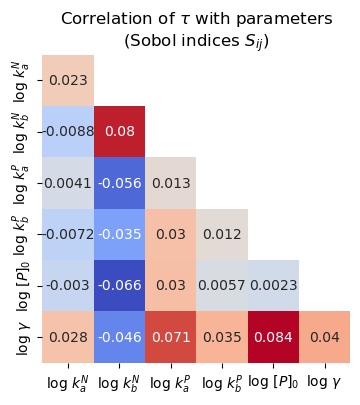

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

S2_matrix = Si['S2']
# Convert the second-order indices into a matrix
num_vars = problem['num_vars']
S2_heatmap = np.zeros((num_vars, num_vars))
mask = np.ones_like(S2_heatmap, dtype=bool)  # Lower triangle mask

# Fill in the matrix (S2 values are stored in a 1D array in SALib, hence this conversion)
for i in range(num_vars):
    for j in range(i+1, num_vars):
        S2_heatmap[j, i] = S2_matrix[i,j]
        mask[j,i] = False
    mask[i,i] = False
    S2_heatmap[i,i] = Si['S1'][i]

# Plot the heatmap using Seaborn with the mask
plt.figure(figsize=(4, 4))
sns.heatmap(S2_heatmap, annot=True, mask=mask, xticklabels=problem['names'], 
            yticklabels=problem['names'], cmap='coolwarm', cbar=False, square=True)
plt.title('Correlation of $\\tau$ with parameters\n(Sobol indices $S_{ij}$)')
plt.show()

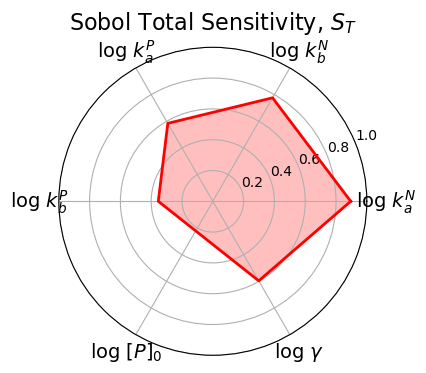

In [6]:
# Number of parameters
parameters = problem['names']
num_vars = len(parameters)

# Compute angle for each parameter
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
first_order_indices = [i for i in Si['S1']]
total_order_indices = [i for i in Si['ST']]
first_order_indices += first_order_indices[:1]
total_order_indices += total_order_indices[:1]
angles += angles[:1]

# Create the figure
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], parameters, fontsize=14)

# Draw ylabels
ax.set_ylim(0, 1)

# Plot data
# ax.plot(angles, first_order_indices, color='b', linewidth=2, label='First Order')
# ax.fill(angles, first_order_indices, color='b', alpha=0.25)

ax.plot(angles, total_order_indices, color='r', linewidth=2, label='Total Order')
ax.fill(angles, total_order_indices, color='r', alpha=0.25)

# Add a title and legend
plt.title('Sobol Total Sensitivity, $S_T$', fontsize=16)
# plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


In [1]:
import numpy as np
import threading

# tau=f(x)
# x = log10(KPN, kaP, kbP, CP0, gamma)
def f_DNA(x):
    '''Given x, calculate the mean residence time through two-state equilbrium model
    
    Inputs:
        x (list): (KPN, kaP, kbP, CP0, gamma) Note that, kbN=120.44/KPN s^-1
        
    Outputs;
        mean residence times (float)
    '''
    
    import sys
    sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
    # modules for direct calculation
    import analytics as ana
    import analyzeEqui as num
    # stochastic simulation (Gillespie)
    from Simulations.odeSolver.Nonly import rxnNetwork, labels
    from Simulations.odeSolver.main import main as numericSolver
    # for generating parameters
    from GenerateParameters import GenParameters
    ######## finish importing ########
    KPN, kaP, kbP, CP0, gamma = np.array(x)
    if kbP == 0:
        parms = GenParameters(
            ifwrite=False, hasTargets = False,
            KPS=lambda KPN: 1e3*KPN, 
            CP0=[CP0], KPP=[np.inf], kbPP_fixed=kbP,
            gamma=[gamma], KPN=[KPN]
        )
    else:
        parms = GenParameters(
            ifwrite=False, hasTargets = False,
            KPS=lambda KPN: 1e3*KPN, 
            CP0=[CP0], KPP=[kaP/kbP], kbPP_fixed=kbP,
            gamma=[gamma], KPN=[KPN]
        )
    # there should be only one set of parameters
    equi = numericSolver(parm_df=parms, labels=labels, model=rxnNetwork, cores=1, ifprint=False)
    # return the mean residence time
    return num.calc_resT_modelA(parms.iloc[0], equi.iloc[0])

# sensitivity analysis
def sobolSA(problem, numberSamples, model, num_cores=1):
    
    from SALib.analyze import sobol
    from SALib.sample import sobol as sobol_sampling
    from tqdm import tqdm 
    import multiprocessing
    
    def model_with_progress(x):
        result = model(x)
        if pbar is not None:
            pbar.update()
        return result
    
    # Generate parameter samples using Saltelli's method (for Sobol analysis)
    param_values = sobol_sampling.sample(problem, numberSamples)

    num_cores = min(num_cores, multiprocessing.cpu_count())  # Get the number of available CPU cores
    print('Number of cores used: ',f'{num_cores}')
    if num_cores > 1:
        pool = multiprocessing.Pool(processes=num_cores)
        Y = np.array(pool.map(model, param_values))
        pool.close()
        pool.join()
    else:
        # Run the model for each set of parameters
        Y = np.array([model(x) for x in tqdm(param_values, desc="Evaluating model", unit="sample")])
    
    # Perform Sobol sensitivity analysis and return 
    return sobol.analyze(problem, Y), Y, param_values

problem = {
    'num_vars': 5,
    'names': ['KPN', 'kaP', 'kbP', 'CP0', 'gamma'],
    'bounds': [
        ([2, 2000]), # KPN
        10.0**np.array([2, 7]), # kaP
        10.0**np.array([-3, 1]), # kbP
        10.0**np.array([-2-6, 2-6]), # CP0
        10.0**np.array([0, 3]), # gamma
    ] 
}

# Perform Sobol sensitivity analysis
Si, Y, param_values = sobolSA(problem, 2**12, f_DNA, num_cores=32)

# Print first-order and total-order Sobol indices
print("First-order Sobol indices:", Si['S1'])
print("Total-order Sobol indices:", Si['ST'])

Number of cores used:  32
First-order Sobol indices: [0.08745357 0.00289473 0.36970641 0.00079625 0.07144761]
Total-order Sobol indices: [0.40266811 0.0132982  0.78067435 0.00842411 0.26408358]


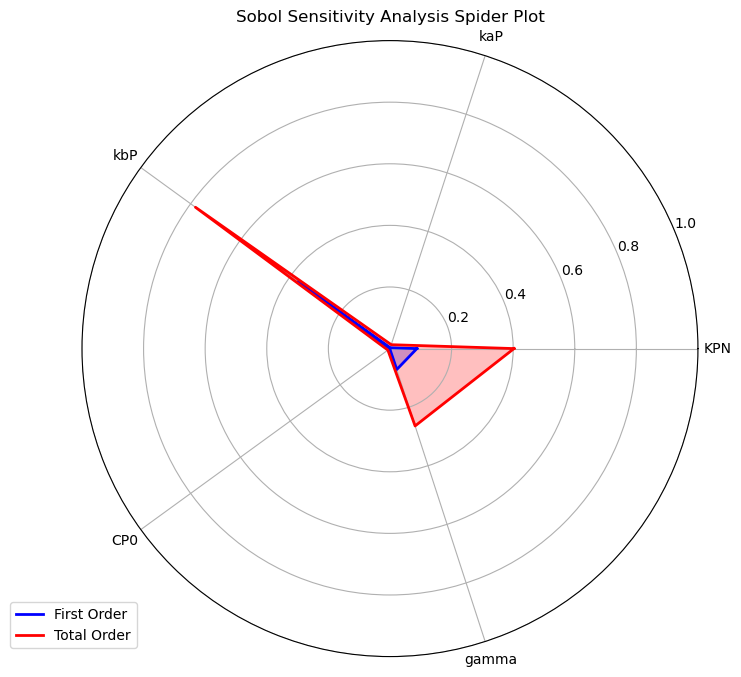

In [2]:
import matplotlib.pyplot as plt

# Number of parameters
parameters = ['KPN', 'kaP', 'kbP', 'CP0', 'gamma']
num_vars = len(parameters)

# Compute angle for each parameter
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
first_order_indices = [i for i in Si['S1']]
total_order_indices = [i for i in Si['ST']]
first_order_indices += first_order_indices[:1]
total_order_indices += total_order_indices[:1]
angles += angles[:1]

# Create the figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], parameters)

# Draw ylabels
ax.set_ylim(0, 1)

# Plot data
ax.plot(angles, first_order_indices, color='b', linewidth=2, label='First Order')
ax.fill(angles, first_order_indices, color='b', alpha=0.25)

ax.plot(angles, total_order_indices, color='r', linewidth=2, label='Total Order')
ax.fill(angles, total_order_indices, color='r', alpha=0.25)

# Add a title and legend
plt.title('Sobol Sensitivity Analysis Spider Plot')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


# Archived

## b) residence time v.s. local protein concentration

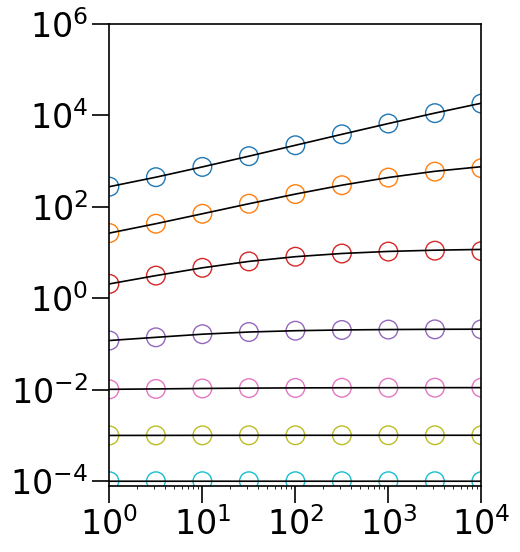

In [5]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':30*scale, 'loc':'best', 'handlelength':1.4*scale, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':30*scale}

fig = plt.figure(figsize=(8*scale,10*scale))
ax = fig.add_subplot(111)
plt.tick_params(length=20*scale,width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width

parm_file = KPP1e8_parm

KPN_list = np.unique(CP62nM_parm['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

# plt.plot([], [], color='black', ls='-', lw=2, label='Analytical')

for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results
    plt.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.resT_Nonly)[KPN_select], 
        color='black', ls='-', lw=2*scale,
    )
    # plot numerical results
    plt.scatter(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8.resT_Nonly)[KPN_select], 
        marker = 'o', s=300*scale,
        edgecolor=colors[i], facecolor='none',
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )

plt.loglog()
plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.xlim([1e0, 1e4])
plt.ylim([0.8e-4,1e6])
plt.yticks([1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6])

plt.show()

## c) protein bound ratio v.s. dimerization

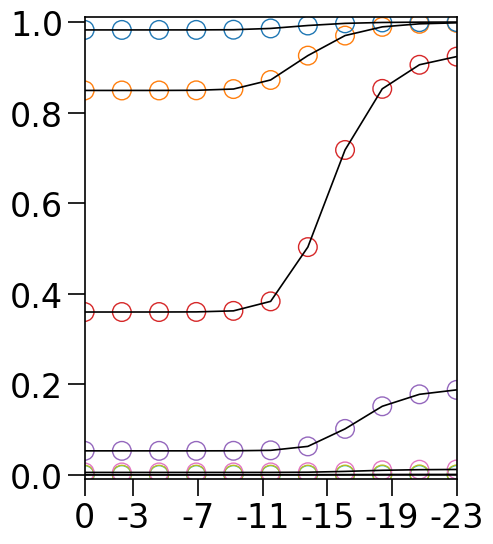

In [6]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':30*scale, 'loc':'best', 'handlelength':1.4*scale, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':30*scale}

fig = plt.figure(figsize=(8*scale,10*scale))
ax = fig.add_subplot(111)
plt.tick_params(length=20*scale,width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width

parm_file = CP62nM_parm

KPN_list = np.unique(CP62nM_parm['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

# plt.plot([], [], color='black', ls='-', lw=2, label='Analytical')

for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results
    plt.plot(
        np.log(parm_file['KPP'][KPN_select]), 
        np.array(CP62nM_ana.pBound_Nonly)[KPN_select], 
        color='black', ls='-', lw=2*scale,
    )
    # plot numerical results
    plt.scatter(
        np.log(parm_file['KPP'][KPN_select]), 
        np.array(CP62nM.pBound_Nonly)[KPN_select], 
        marker = 'o', s=300*scale,
        edgecolor=colors[i], facecolor='none',
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )

plt.xticks(**tickfont)
plt.yticks(**tickfont)
# plt.legend(**legend)

plt.xlim([np.log(1e0), np.log(1e9)])
plt.xticks([23, 19, 15, 11, 7, 3, 0], [-23, -19, -15, -11, -7, -3, 0])
plt.ylim([-0.01,1.01])

plt.show()

## d) protein bound ratio v.s. local protein concentration

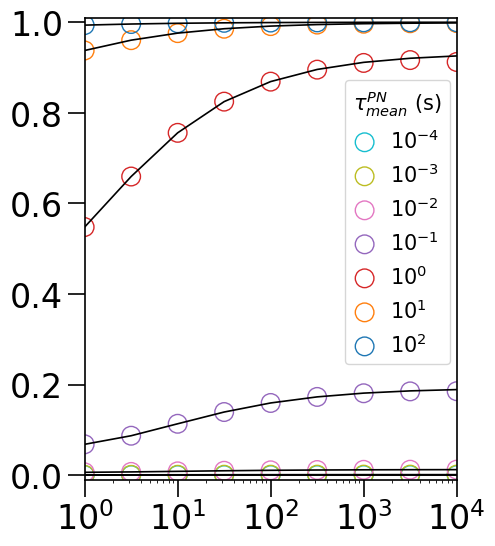

In [7]:
scale = 0.6
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':40*scale}
legend = {'fontsize':25*scale, 'loc':[0.7, 0.25], 'handlelength':1.4*scale, 
          'title':'$\\tau_{mean}^{PN}$ (s)', 'title_fontsize':25*scale}

fig = plt.figure(figsize=(8*scale,10*scale))
ax = fig.add_subplot(111)
plt.tick_params(length=20*scale,width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width

parm_file = KPP1e8_parm

KPN_list = np.unique(CP62nM_parm['KPN'])
colors = plt.cm.tab10_r(np.linspace(0, 1, len(KPN_list)))

# plt.plot([], [], color='black', ls='-', lw=2, label='Analytical')

for i, KPNi in enumerate(KPN_list):
    # select data
    KPN_select = (parm_file['KPN']==KPNi)
    # plot analytical results
    plt.plot(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8_ana.pBound_Nonly)[KPN_select], 
        color='black', ls='-', lw=2*scale,
    )
    # plot numerical results
    plt.scatter(
        parm_file['CP0'][KPN_select]*1e9/0.6022, 
        np.array(KPP1e8.pBound_Nonly)[KPN_select], 
        marker = 'o', s=300*scale,
        edgecolor=colors[i], facecolor='none',
        label='$10^{%.0f}$'%(np.log10(1/np.unique(parm_file['kbPN'][KPN_select])))
    )

plt.semilogx()
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.legend(**legend)

plt.xlim([1e0, 1e4])
plt.ylim([-0.01,1.01])

plt.show()